In [123]:
import os
import torch
from skimage import io, transform

In [124]:
import pandas as pd

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [126]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

## Annotation File

In [127]:
landmarks_frame = pd.read_csv("data/faces/face_landmarks.csv")

In [128]:
landmarks_frame

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,matt-mathes.jpg,85,152,83,173,83,195,85,217,91,...,160,224,190,225,162,236,151,237,141,235
65,person-7.jpg,32,65,33,76,34,86,34,97,37,...,79,98,91,99,79,99,74,99,69,99
66,person.jpg,78,83,79,93,80,103,81,112,85,...,119,115,132,114,120,121,114,122,109,121
67,person_TjahjonoDGondhowiardjo.jpg,41,92,41,103,43,114,44,125,48,...,85,130,94,130,85,128,81,128,77,128


In [129]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

In [130]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

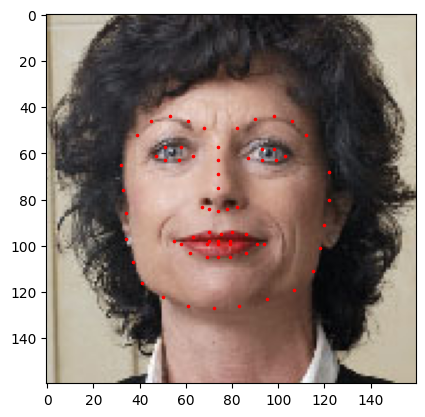

In [131]:
plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)),
               landmarks)
plt.show()

## Custom DataSet Class

In [132]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks Dataset
    

    :param Dataset: _description_
    :type Dataset: _type_
    """

    def __init__(self, csv_path, root_dir, transform=None):
        """Initializer of the Class

        :param csv_path: File Path where annotation and filename are mapped
        :type csv_path: str

        :param root_dir: Directory with All Images
        :type root_dir: str

        :param transform: Optional Transform to be Applied
        :type transform: _type_, optional
        """

        self.landmarks_frame = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.transform = transform

    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        """Retrieve 1 image for given index

        :param idx: _description_
        :type idx: _type_
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])

        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)

        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

        
        

In [133]:
face_dataset = FaceLandmarksDataset(csv_path='data/faces/face_landmarks.csv',
                                    root_dir='data/faces/')

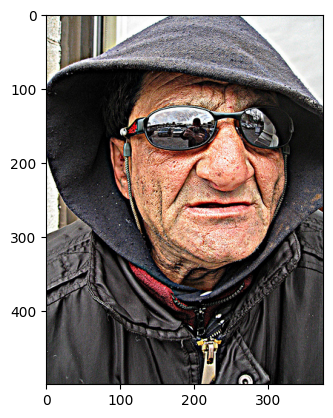

In [134]:
plt.imshow(face_dataset[15]['image'])

0 (324, 215, 3) (68, 2)


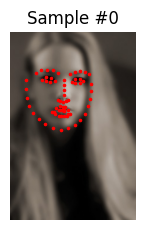

1 (500, 333, 3) (68, 2)


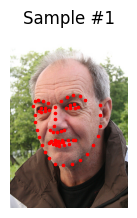

2 (250, 258, 3) (68, 2)


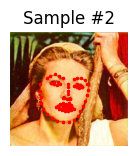

3 (434, 290, 3) (68, 2)


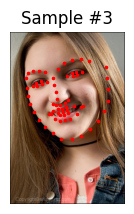

In [135]:
fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

## Images Transform
1. Sample's Above don't have same size

In [136]:
sample['image'].shape[:2]

(434, 290)

In [137]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        ## Original Height & Width
        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            ## Say output size is 500 ##
            ## H: 434 | W: 290 ##
            ## New Size ##
            ## 748, 500 ##
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h

            new_h, new_w = int(new_h), int(new_w)

            img = transform.resize(image, (new_h, new_w))

            ## Scaling the landmarks ##
            landmarks = landmarks * [new_w / w, new_h / h]

            return {'image': img, 'landmarks': landmarks}

In [138]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

In [139]:
class ToTensor(object):
    """ Convert ndarrays in sample to Tensors """

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # Torch Image: C x H x W

        image = image.transpose((2, 0, 1))

        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose Transform

In [140]:
scale = Rescale(256)
crop = RandomCrop(128)

In [141]:
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

In [142]:
## Apply Each of the Above Transdorm on sample Image

In [143]:
fig = plt.figure()
sample = face_dataset[68]

<Figure size 640x480 with 0 Axes>

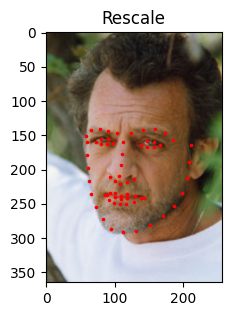

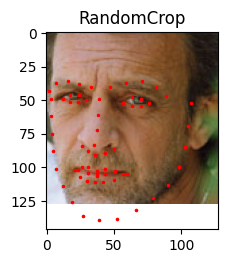

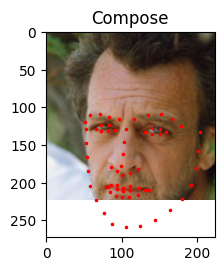

In [144]:
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i +1)

    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

## What We have Learned

Everytime when datset is sampled

1. An Image is read from the file on Fly
2. Transformations are applied
3. Data is Augmented on Training

In [145]:
transformed_dset = FaceLandmarksDataset(csv_path='data/faces/face_landmarks.csv',
                                        root_dir='data/faces/',
                                        transform=transforms.Compose([
                                            Rescale(256),
                                            RandomCrop(224),
                                            ToTensor()
                                        ]))

In [146]:
for i, sample in enumerate(transformed_dset):
    print(i, sample['image'].size(), sample['landmarks'].size())
    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


## DataLoader
Using for Loop for fetching data in fly is good but can be made even faster by using Multiprocessing, plus shuffling & batching is also added

In [152]:
dataloader = DataLoader(transformed_dset, batch_size=6, shuffle=True, num_workers=0)

In [153]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

0 torch.Size([6, 3, 224, 224]) torch.Size([6, 68, 2])
1 torch.Size([6, 3, 224, 224]) torch.Size([6, 68, 2])
2 torch.Size([6, 3, 224, 224]) torch.Size([6, 68, 2])
3 torch.Size([6, 3, 224, 224]) torch.Size([6, 68, 2])
4 torch.Size([6, 3, 224, 224]) torch.Size([6, 68, 2])
5 torch.Size([6, 3, 224, 224]) torch.Size([6, 68, 2])
6 torch.Size([6, 3, 224, 224]) torch.Size([6, 68, 2])


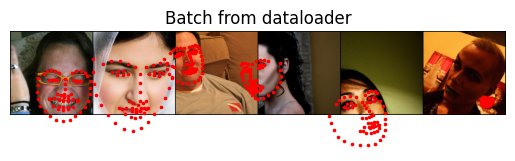

In [154]:
if __name__ == "__main__":
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['image'].size(),
              sample_batched['landmarks'].size())
    
        # observe 4th batch and stop.
        if i_batch == 6:
            plt.figure()
            show_landmarks_batch(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break

In [155]:
sample_batched['image'].shape

torch.Size([6, 3, 224, 224])